# pypsps: demo of learning UTE and ATE from simulated datasets

This notebook illustrates how to use `pypsps` for

* how to train PSPS deep nets from causal (simulated) datasets
 
* how to use model predictions/estimates to obtain UTE / ATE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import tensorflow as tf
import tensorflow.keras as tfk

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

In [3]:
import pypsps
import pypsps.keras.layers
import pypsps.keras.losses
import pypsps.keras.metrics
import pypsps.keras.models
import pypsps.keras.callbacks
import pypsps.utils
import pypsps.inference
import pypsps.datasets

import pypress # for regularizers

In [49]:
import sklearn.metrics

def _eval_propensity(y_true, y_score):

    y_comb = pd.DataFrame({"treatment": y_true, "propensity_score": y_score})
    sns.displot(data=y_comb, x="propensity_score", hue="treatment")
    plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = sklearn.metrics.auc(recall, precision)
    print(auc_precision_recall, output_data[:, 1].mean())

    plt.plot(recall, precision)
    plt.title("AUPR")
    plt.grid()
    plt.show()



def _eval_propensity(y_true, y_score, figsize=(12, 5), hist_kws=None, pr_kws=None):
    """
    Plot propensity‐score distributions by treatment and the Precision–Recall curve.
    
    Args:
      y_true (array-like): binary treatment labels (0/1).
      y_score (array-like): predicted propensity scores in [0,1].
      figsize (tuple): overall figure size.
      hist_kws (dict): kwargs passed to seaborn.histplot().
      pr_kws (dict): kwargs passed to plt.plot() for PR curve.
    
    Returns:
      fig, (ax_hist, ax_pr): Matplotlib Figure and Axes.
    """
    hist_kws = {} if hist_kws is None else hist_kws
    pr_kws   = {} if pr_kws   is None else pr_kws

    # Prepare data
    df = pd.DataFrame({
        "treatment": y_true,
        "propensity": y_score
    })

    # Compute PR curve & AUPR
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_true, y_score)
    aupr = sklearn.metrics.auc(recall, precision)

    # Create subplots
    fig, (ax_hist, ax_pr) = plt.subplots(1, 2, figsize=figsize)

    # 1) Propensity distributions
    sns.histplot(
        data=df, x="propensity", hue="treatment", 
        element="step", stat="density", common_norm=False,
        palette=["C0","C1"], ax=ax_hist, **hist_kws
    )
    ax_hist.grid(True)
    ax_hist.set_title("Propensity Score Distribution")
    ax_hist.set_xlabel("Propensity Score")
    ax_hist.set_ylabel("Density")
    ax_hist.legend(title="Treatment")

    # 2) Precision–Recall curve
    ax_pr.plot(recall, precision, label=f"AUPR = {aupr:.3f}", **pr_kws)
    ax_pr.set_title("Precision–Recall Curve")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    plt.axhline(y=y_true.mean(), color='red', linestyle='--', label='Baseline')
    ax_pr.grid(True, linestyle="--", alpha=0.5)
    ax_pr.legend(loc="lower left")

    plt.tight_layout()
    return fig, (ax_hist, ax_pr)

# Load datasets

In [7]:
feat_cols = []
treat_col = None
outcome_col = None

## Kang-Schafer

In [8]:
ks_sampler = pypsps.datasets.KangSchafer(true_ate=10, seed=123) 
ks_data = ks_sampler.sample(n_samples=1000)
df = ks_data.to_data_frame()

treat_col = "treatment"
outcome_col = "outcome"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))
feat_cols = [c for c in feat_cols if "x" in c]

df.head()

,outcome,treatment,z1,z2,z3,z4,x1,x2,x3,x4,propensity_score
0,185.861788,1,-1.085631,0.997345,0.282978,-1.506295,0.581110,10.745574,0.202998,379.901059,0.840799
1,185.488662,1,-0.578600,1.651437,-2.426679,-0.428913,0.748787,11.058150,0.282511,450.395521,0.886339
2,222.810098,0,1.265936,-0.866740,-0.678886,-0.094709,1.883192,9.809357,0.180959,362.466410,0.179445
3,229.073054,0,1.491390,-0.638902,-0.443982,-0.434351,2.107906,9.882625,0.188639,358.221742,0.160244
4,318.044041,0,2.205930,2.186786,1.004054,0.386186,3.013087,10.216971,0.326506,509.539087,0.197472


# Lalonde

In [9]:
l_data = pypsps.datasets.lalonde.Lalonde(observational_control=True, add_is_unemployed_features=True)
df = l_data.to_data_frame()

treat_col = "treatment"
outcome_col = "earnings1978"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))

df.head()

Reading data from http://www.nber.org/~rdehejia/data/nswre74_control.txt
Reading data from http://www.nber.org/~rdehejia/data/nswre74_treated.txt
Reading data from http://www.nber.org/~rdehejia/data/cps_controls.txt


,earnings1978,treatment,age,nodegree,black,hispanic,earnings1975,education,earnings1974,married,is_unemployed_1974,is_unemployed_1975
0,9930.0460,1.0,37.0,1.0,1.0,0.0,0.0,11.0,0.0,1.0,1.0,1.0
1,3595.8940,1.0,22.0,1.0,0.0,1.0,0.0,9.0,0.0,0.0,1.0,1.0
2,24909.4500,1.0,30.0,0.0,1.0,0.0,0.0,12.0,0.0,0.0,1.0,1.0
3,7506.1460,1.0,27.0,1.0,1.0,0.0,0.0,11.0,0.0,0.0,1.0,1.0
4,289.7899,1.0,33.0,1.0,1.0,0.0,0.0,8.0,0.0,0.0,1.0,1.0


## Lunceford-Davidian

In [10]:
ld_sampler = pypsps.datasets.LuncefordDavidian(association="strong", seed=123)
ld_data = ld_sampler.sample(n_samples=1000)
df = ld_data.to_data_frame()

treat_col = "treatment"
outcome_col = "outcome"
feat_cols = list(set(df.columns) - set([treat_col, outcome_col]))
feat_cols = [c for c in feat_cols if "x" in c]

df.head()

,outcome,treatment,x1,x2,x3,z1,z2,z3,propensity_score
0,4.288748,1,-0.344101,0.499007,0,-1.492195,-0.280584,0,0.376163
1,-1.731983,1,0.750124,-0.443058,0,0.758944,-0.303332,0,0.671706
2,1.831487,0,-1.185921,-1.241506,0,-0.720672,0.775033,0,0.508337
3,1.010604,1,-0.206458,-1.547661,0,1.530919,1.278715,0,0.690983
4,3.079055,1,-1.812288,-1.207898,0,0.379140,1.016479,0,0.410322


In [11]:
ld_data.naive_ate()

np.float64(1.3277185467523047)

# Summary stats of Causal dataset

In [12]:
print(df.groupby(treat_col).mean().T.round(2))

treatment            0     1
outcome           0.44  1.77
x1               -1.05 -0.82
x2               -0.88 -1.17
x3                0.20  0.28
z1                0.97  1.05
z2                0.98  1.03
z3                0.38  0.40
propensity_score  0.50  0.59


In [13]:
feat_cols

['x3', 'x1', 'x2']

# Feature, treatment, outcome: setup for model training and inference

In [14]:
X, treatment, y = df[feat_cols].astype(float), df[[treat_col]], df[[outcome_col]]
X.shape, treatment.shape, y.shape

((1000, 3), (1000, 1), (1000, 1))

In [15]:
# Naive difference in means
df.groupby(treat_col)[outcome_col].mean()

treatment
0    0.437886
1    1.765604
Name: outcome, dtype: float64

In [16]:
ld_data.naive_ate()

np.float64(1.3277185467523047)

In [17]:
# Scale features using a standard scaler (for sake of illustration don't do train/test split; in practice use train/test split for scaling as well)
import sklearn

# scale only features that have > 2 values (non-binary)
val_counts = X.nunique()
binary_cols = val_counts[val_counts == 2].index.tolist()

X_nonbinary = X.drop(binary_cols, axis=1)
X_s = pd.concat([X[binary_cols], 
                 pd.DataFrame(sklearn.preprocessing.scale(X_nonbinary), index=X_nonbinary.index, columns=X_nonbinary.columns)], axis=1)
X_s

,x3,x1,x2
0,0.0,0.605236,1.621582
1,0.0,1.732671,0.624191
2,0.0,-0.262133,-0.221148
3,0.0,0.747056,-0.545282
4,0.0,-0.907510,-0.185566
...,...,...,...
995,0.0,-1.397577,-0.532454
996,0.0,-1.568665,0.766107
997,0.0,-1.629278,0.407233
998,0.0,-1.040693,-1.900509


# Model architecture

In [21]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(4, X_s.shape[1])
model.summary()

/Users/georg/Projects/pypsps/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn         │ (None, 3)         │         12 │ features[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn_and_tr… │ (None, 4)         │          0 │ features_bn[0][0… │
│ (Concatenate)       │                   │            │ treatment[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inputs_processing   │ (None, 10)        │         50 │ features_bn_and_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10)        │          0 │ inputs_processin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │         40 │ features_bn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome_hidden_and… │ (None, 14)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_0    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_1    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_2    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_3    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_0       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_1       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_2       │ (None, 1)         │          1 │ features_bn_and_

 Total params: 680 (2.66 KB)

 Trainable params: 634 (2.48 KB)

 Non-trainable params: 46 (184.00 B)

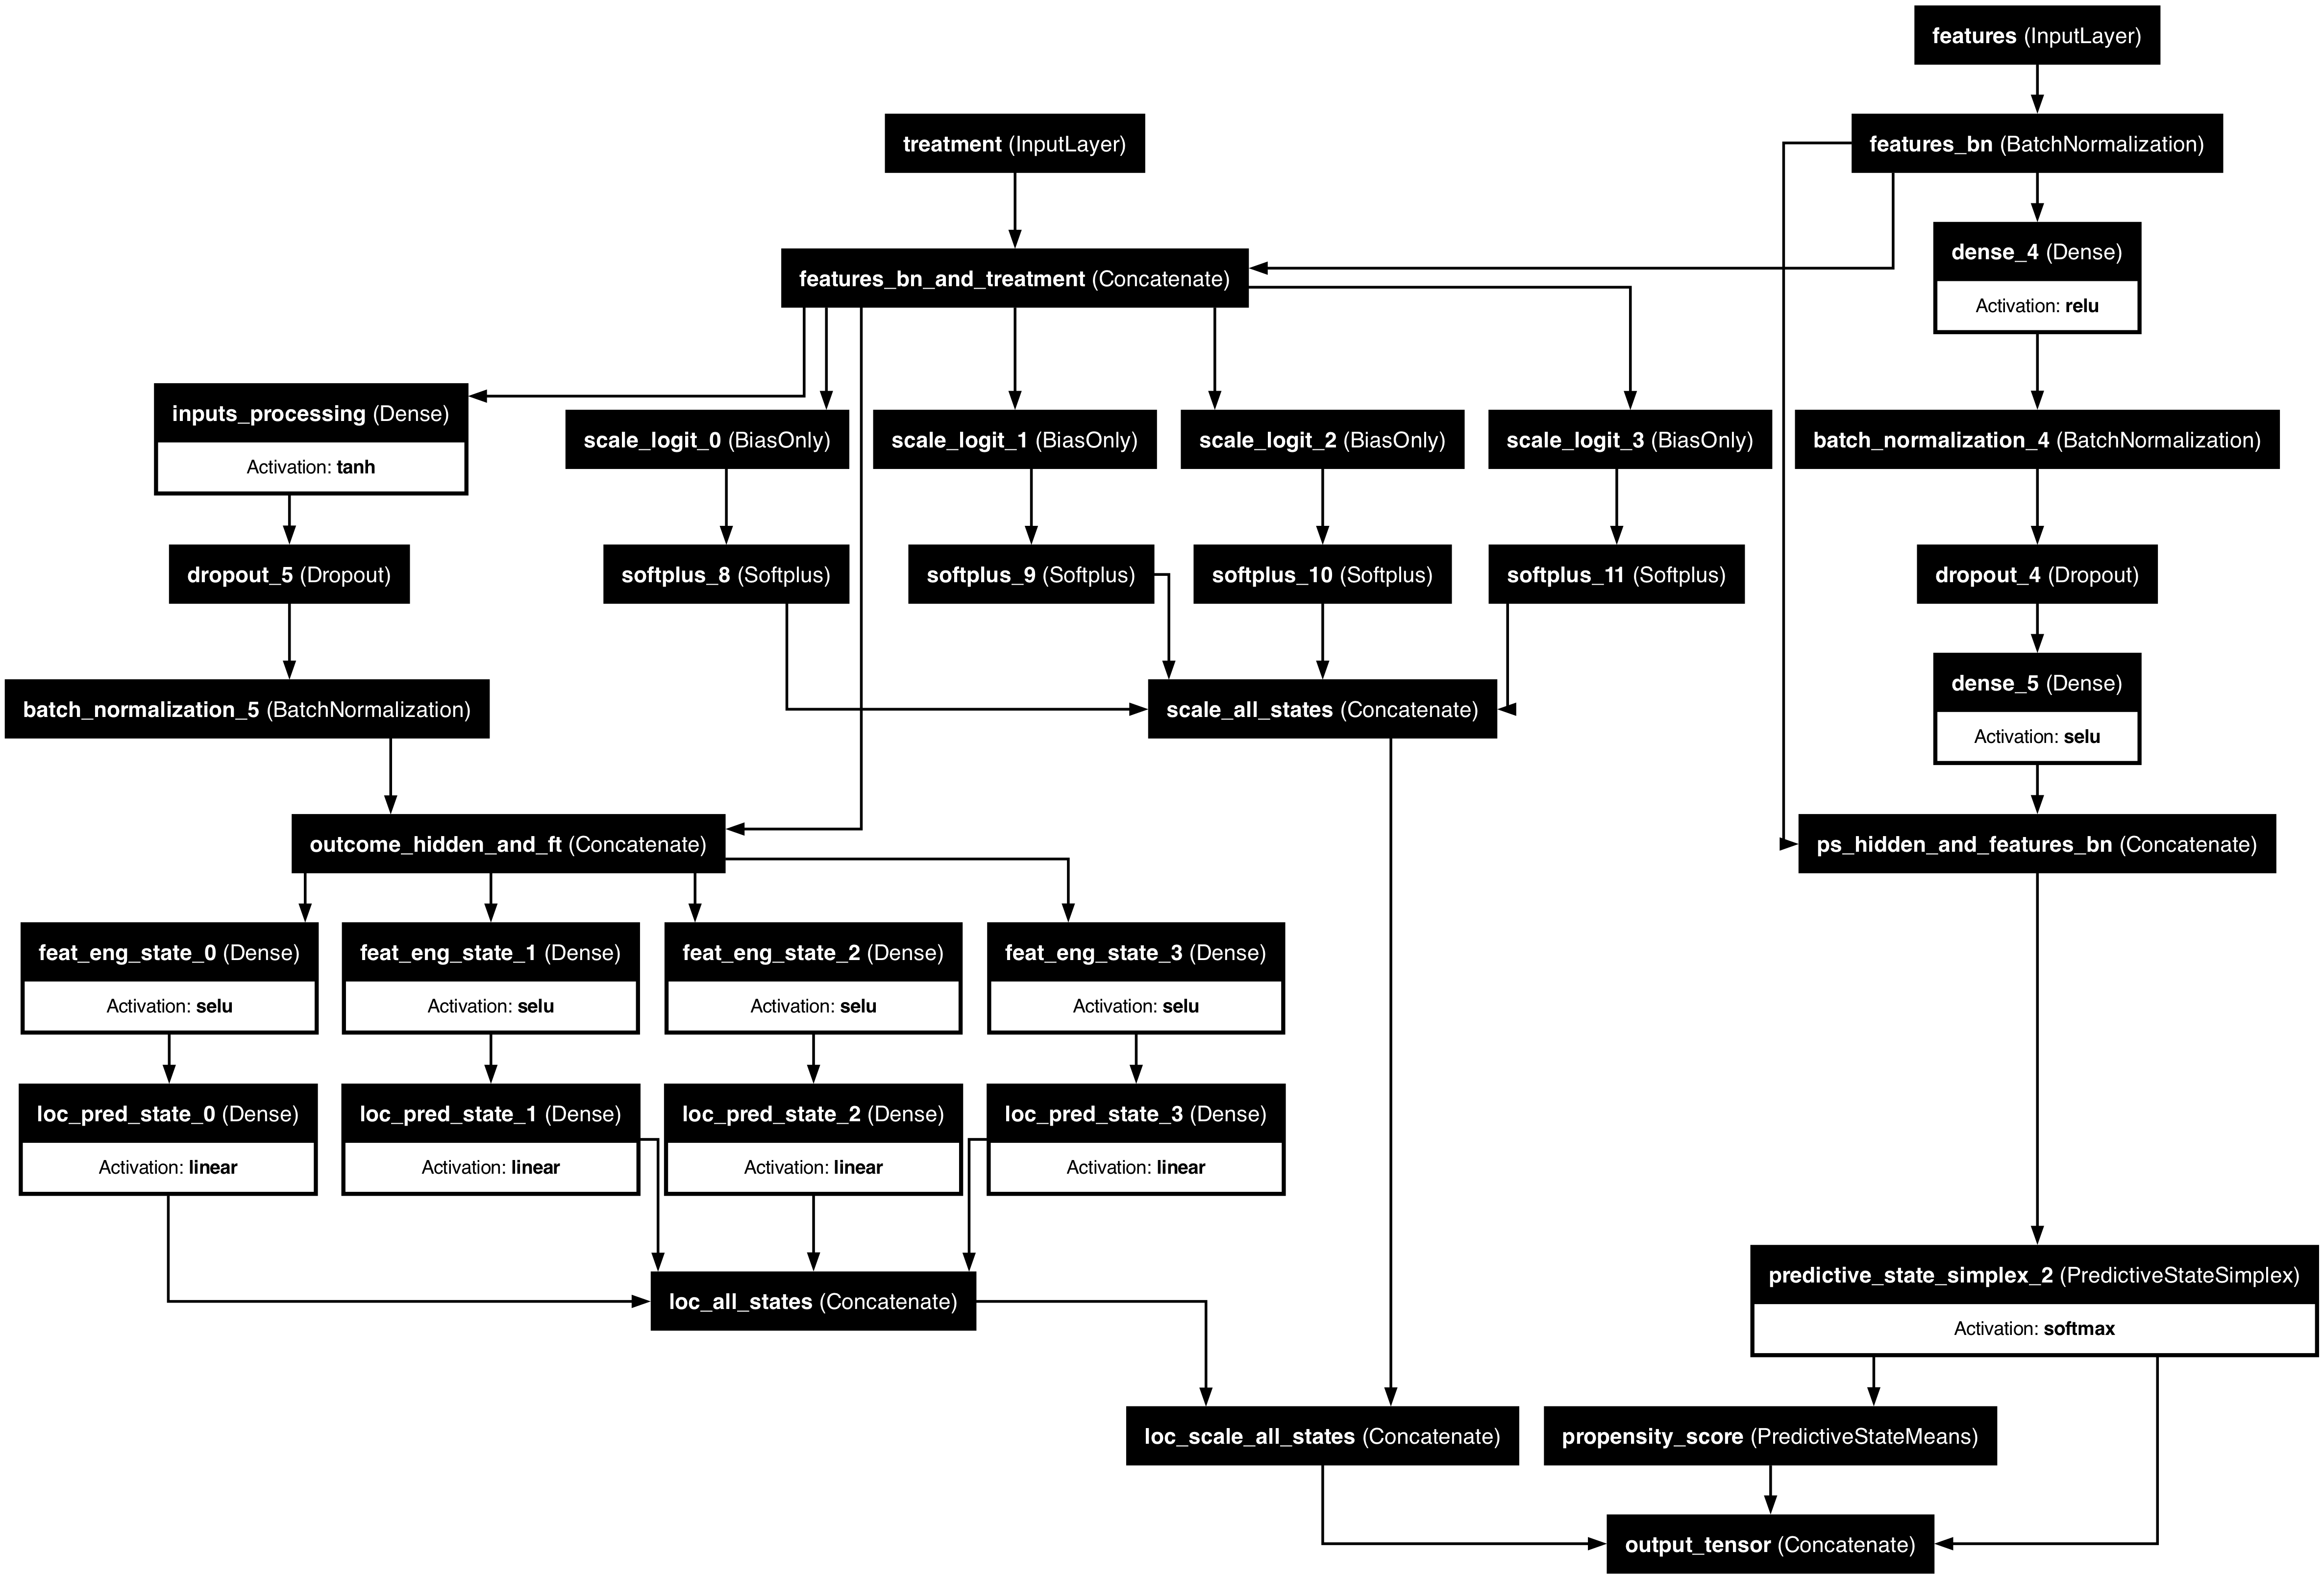

In [22]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_layer_activations=True)

<Axes: >

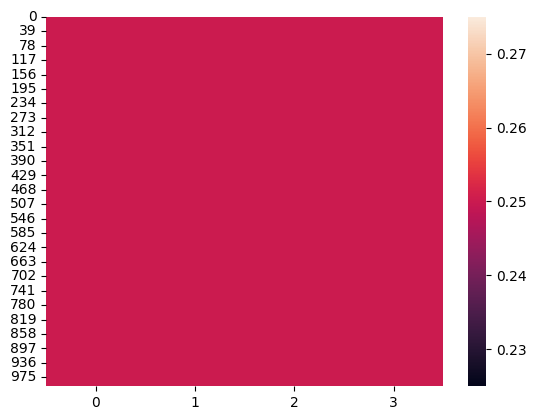

In [23]:
inputs = [X_s.values, treatment.values]
outputs = np.hstack([y.values, treatment.values])

preds = model.predict(inputs, verbose=0)

outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(preds, n_outcome_pred_cols=2, n_treatment_pred_cols=1)
sns.heatmap(weights)

## Train model

In [24]:
# Preparet inputs and outputs (y_true) for losses / metrics and .fit() / .predict()
input_data = [X_s.values, treatment.values]
output_data = np.hstack([y.values, treatment.values])

# pre-training model predictions
y_pred = model.predict(input_data, verbose=0)
y_pred.shape

(1000, 13)

In [25]:
op, wp, tp = pypsps.utils.split_y_pred(y_pred, 
                                       model.loss._outcome_loss._n_outcome_pred_cols,
                                       model.loss._treatment_loss._n_treatment_pred_cols)
op

array([[ 0.03337532,  0.8420273 ,  0.48446125, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [-0.181974  ,  1.4705384 ,  0.13113506, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [ 0.31107405, -0.5760963 ,  0.02982389, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       ...,
       [ 0.45191413, -1.2027794 ,  0.43268508, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [ 1.2257771 , -2.5149965 ,  0.19827074, ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ],
       [ 0.08990717,  1.0300355 ,  0.2880472 , ...,  0.6931472 ,
         0.6931472 ,  0.6931472 ]], dtype=float32)

In [26]:
tf.random.set_seed(10)
model = pypsps.keras.models.build_toy_model(5, X_s.shape[1])
model.summary()

/Users/georg/Projects/pypsps/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn         │ (None, 3)         │         12 │ features[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_bn_and_tr… │ (None, 4)         │          0 │ features_bn[0][0… │
│ (Concatenate)       │                   │            │ treatment[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inputs_processing   │ (None, 10)        │         50 │ features_bn_and_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 10)        │          0 │ inputs_processin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │         40 │ features_bn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dropout_7[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outcome_hidden_and… │ (None, 14)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ features_bn_and_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 10)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_0    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_1    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_2    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_3    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feat_eng_state_4    │ (None, 5)         │         75 │ outcome_hidden_a… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_0       │ (None, 1)         │          1 │ features_bn_and_… │
│ (BiasOnly)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scale_logit_1       │ (None, 1)         │          1 │ features_bn_and_

 Total params: 777 (3.04 KB)

 Trainable params: 731 (2.86 KB)

 Non-trainable params: 46 (184.00 B)

In [27]:
psps_outcome_loss = pypsps.keras.losses.OutcomeLoss(
    loss=pypsps.keras.neglogliks.NegloglikNormal(reduction="none"), reduction="sum_over_batch_size",
    n_outcome_true_cols=1,
    n_outcome_pred_cols=2,
    n_treatment_pred_cols=1,
)
psps_treat_loss = pypsps.keras.losses.TreatmentLoss(loss=tf.keras.losses.BinaryCrossentropy(reduction="none"), 
                                                    reduction="sum_over_batch_size",
                                                       n_outcome_true_cols=1,
    n_outcome_pred_cols=2,
    n_treatment_pred_cols=1,)
psps_outcome_loss(output_data, y_pred), psps_treat_loss(output_data, y_pred)

(<tf.Tensor: shape=(), dtype=float32, numpy=5.997352600097656>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6928647756576538>)

In [30]:
psps_causal_loss = pypsps.keras.losses.CausalLoss(outcome_loss=psps_outcome_loss,
                                  treatment_loss=psps_treat_loss,
                                  alpha=1.,
                                  outcome_loss_weight=0.01,
                                  predictive_states_regularizer=pypress.keras.regularizers.DegreesOfFreedom(
                                      0.01, target=5 - 1),
                                  reduction="sum_over_batch_size")

# Test loss function
psps_causal_loss(output_data, y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=0.7828382849693298>

In [34]:
model.compile(loss=psps_causal_loss, 
              optimizer=tfk.optimizers.Nadam(learning_rate=0.01), 
              metrics=[pypsps.keras.metrics.PropensityScoreBinaryCrossentropy(n_outcome_pred_cols=1, 
                                                                              n_treatment_pred_cols=1),
                      pypsps.keras.metrics.PropensityScoreAUC(curve="PR", n_outcome_pred_cols=1, n_treatment_pred_cols=1),
                      pypsps.keras.metrics.OutcomeMeanSquaredError(n_outcome_pred_cols=1, n_treatment_pred_cols=1, n_outcome_true_cols=1)])

history = model.fit(input_data, output_data, epochs=50, batch_size=64,
                    verbose=2, validation_split=0.2,
                    callbacks=pypsps.keras.callbacks.recommended_callbacks())


Epoch 1/50
Epoch 1: loss=0.7669, mean_squared_error=5.9732, propensity_score_auc_6=0.6369, propensity_score_binary_crossentropy=0.6812, val_loss=0.7521, val_mean_squared_error=4.0171, val_propensity_score_auc_6=0.6070, val_propensity_score_binary_crossentropy=0.6807, learning_rate=0.0100
13/13 - 3s - 208ms/step - loss: 0.7669 - mean_squared_error: 5.9732 - propensity_score_auc_6: 0.6369 - propensity_score_binary_crossentropy: 0.6812 - val_loss: 0.7521 - val_mean_squared_error: 4.0171 - val_propensity_score_auc_6: 0.6070 - val_propensity_score_binary_crossentropy: 0.6807 - learning_rate: 0.0100
Epoch 2/50
13/13 - 0s - 4ms/step - loss: 0.7085 - mean_squared_error: 6.8904 - propensity_score_auc_6: 0.6764 - propensity_score_binary_crossentropy: 0.6495 - val_loss: 0.7334 - val_mean_squared_error: 8.7968 - val_propensity_score_auc_6: 0.6094 - val_propensity_score_binary_crossentropy: 0.6735 - learning_rate: 0.0100
Epoch 3/50
13/13 - 0s - 3ms/step - loss: 0.6941 - mean_squared_error: 11.8226 

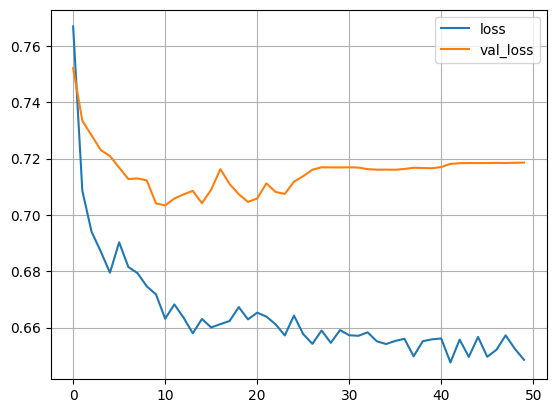

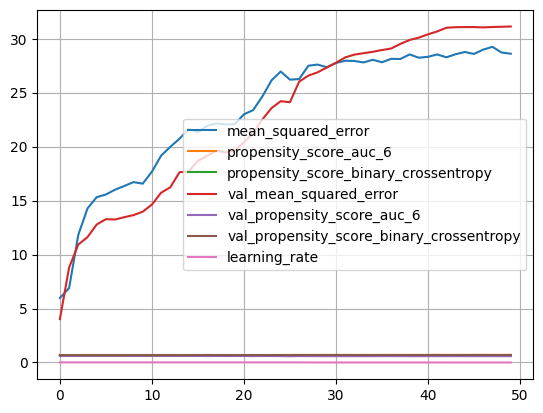

In [50]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
plt.grid()
plt.show()
pd.DataFrame(history.history).drop(["loss", "val_loss"], axis=1).plot()
plt.grid()


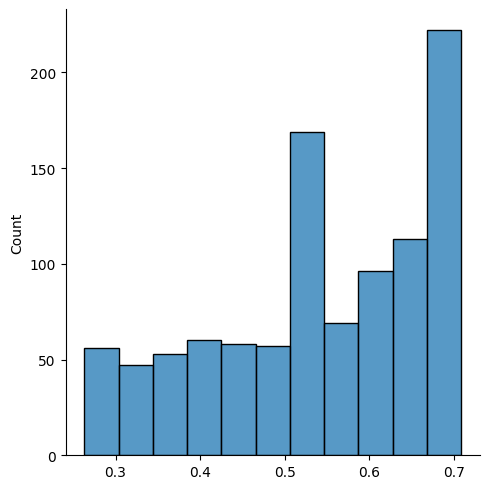

In [51]:
y_pred = model.predict(input_data, verbose=0)
outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(y_pred, 
                                                                     model.loss._outcome_loss._n_outcome_pred_cols,
                                                                     model.loss._treatment_loss._n_treatment_pred_cols)
sns.displot(pd.Series(propensity_score.ravel()))

/var/folders/8z/h14m58j90330cxkpzsn4z09h0000gn/T/ipykernel_35011/707384023.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_hist.legend(title="Treatment")
/var/folders/8z/h14m58j90330cxkpzsn4z09h0000gn/T/ipykernel_35011/1244268853.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


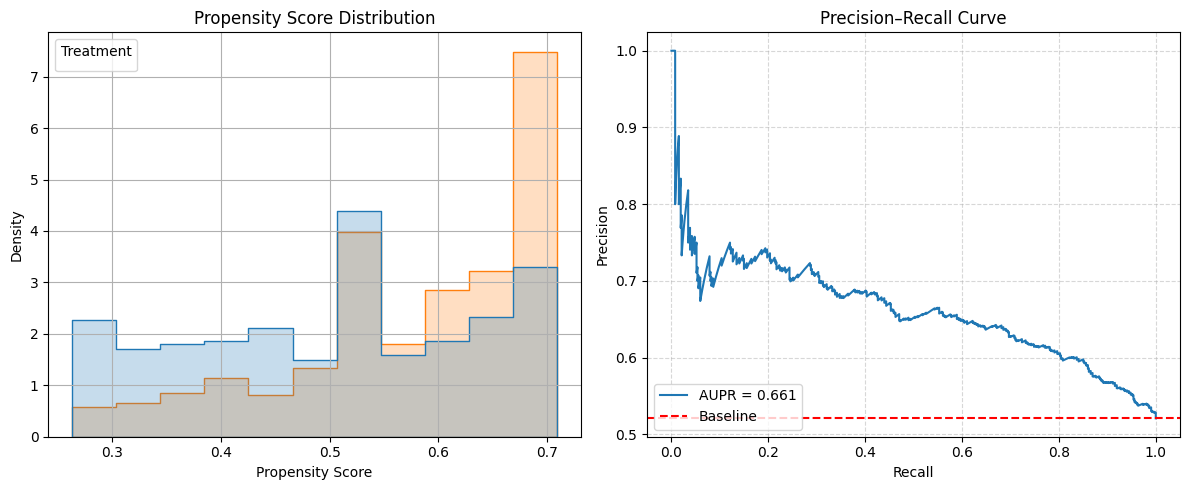

<Axes: >

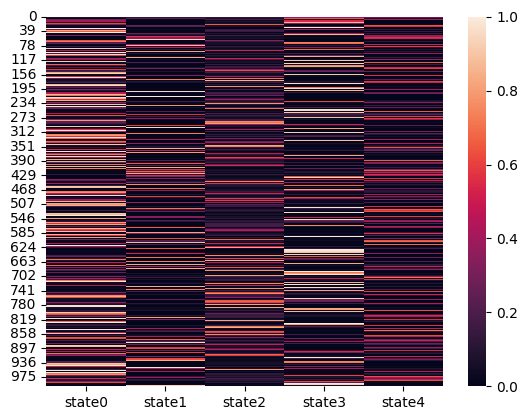

In [48]:
y_pred = model.predict(input_data, verbose=0)
outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(y_pred,
                                                                     model.loss._outcome_loss._n_outcome_pred_cols,
                                                                     model.loss._treatment_loss._n_treatment_pred_cols)
fig, _ = _eval_propensity(output_data[:, 1], propensity_score.ravel())
fig.show()
plt.show()

weights_df = pd.DataFrame(weights, index=X_s.index, columns=["state" + str(i) for i in range(weights.shape[1])])
sns.heatmap(weights_df.round(2))

In [53]:
psps_causal_loss = pypsps.keras.losses.CausalLoss(outcome_loss=psps_outcome_loss,
                                  treatment_loss=psps_treat_loss,
                                  alpha=1.,
                                  outcome_loss_weight=1.0,
                                  predictive_states_regularizer=pypress.keras.regularizers.DegreesOfFreedom(0.01, df=5 - 1),
                                  reduction="sum_over_batch_size")
# Test loss function
print(psps_causal_loss(output_data, y_pred))

model.compile(loss=psps_causal_loss, 
              optimizer=tfk.optimizers.Nadam(learning_rate=0.01), 
              metrics=[pypsps.keras.metrics.PropensityScoreBinaryCrossentropy(n_outcome_pred_cols=1, n_treatment_pred_cols=1)])

history = model.fit(input_data, output_data, epochs=50, batch_size=64,
                    verbose=2, validation_split=0.2,
                    # callbacks=all_callbacks
                   )

tf.Tensor(2.6741884, shape=(), dtype=float32)
Epoch 1/50
13/13 - 2s - 185ms/step - loss: 2.6539 - propensity_score_binary_crossentropy: 0.6463 - val_loss: 2.7065 - val_propensity_score_binary_crossentropy: 0.6705
Epoch 2/50
13/13 - 0s - 3ms/step - loss: 2.5693 - propensity_score_binary_crossentropy: 0.6429 - val_loss: 2.6519 - val_propensity_score_binary_crossentropy: 0.6760
Epoch 3/50
13/13 - 0s - 3ms/step - loss: 2.5346 - propensity_score_binary_crossentropy: 0.6393 - val_loss: 2.6280 - val_propensity_score_binary_crossentropy: 0.6786
Epoch 4/50
13/13 - 0s - 3ms/step - loss: 2.5041 - propensity_score_binary_crossentropy: 0.6446 - val_loss: 2.5894 - val_propensity_score_binary_crossentropy: 0.6752
Epoch 5/50
13/13 - 0s - 3ms/step - loss: 2.4756 - propensity_score_binary_crossentropy: 0.6423 - val_loss: 2.5774 - val_propensity_score_binary_crossentropy: 0.6770
Epoch 6/50
13/13 - 0s - 3ms/step - loss: 2.4707 - propensity_score_binary_crossentropy: 0.6456 - val_loss: 2.5684 - val_propens

/var/folders/8z/h14m58j90330cxkpzsn4z09h0000gn/T/ipykernel_35011/1999357834.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_hist.legend(title="Treatment")


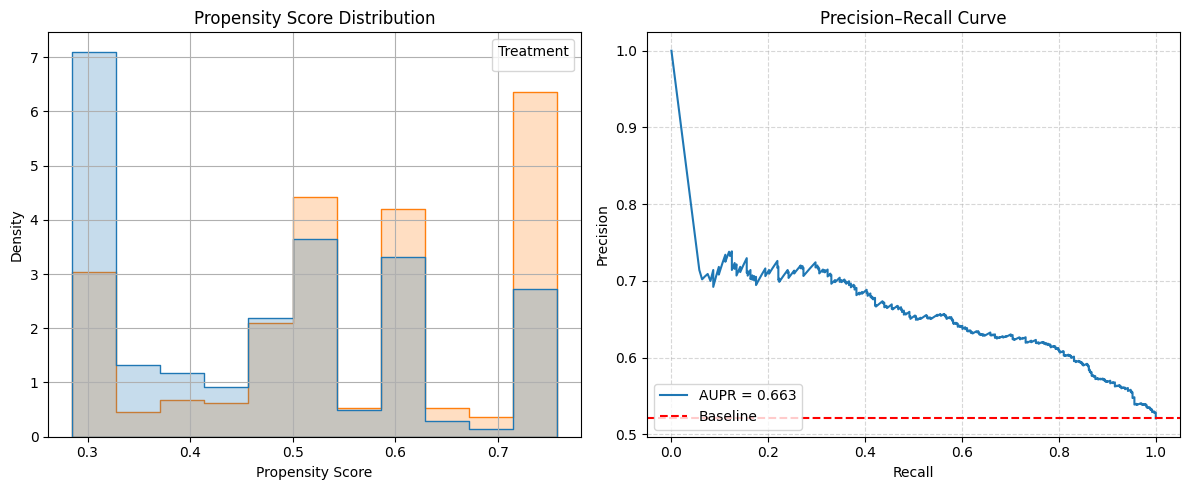

<Axes: >

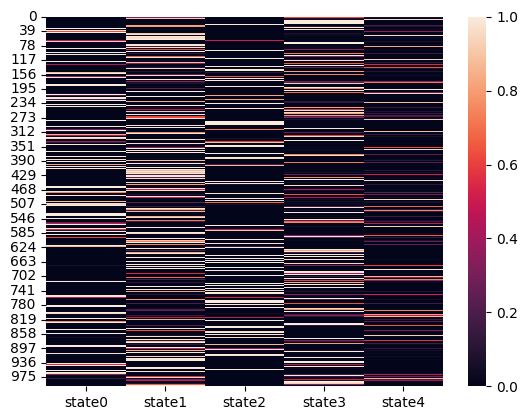

In [55]:
y_pred = model.predict(input_data, verbose=0)
outcome_preds, weights, propensity_score = pypsps.utils.split_y_pred(y_pred,
                                                                     model.loss._outcome_loss._n_outcome_pred_cols,
                                                                     model.loss._treatment_loss._n_treatment_pred_cols)
fig, _ = _eval_propensity(output_data[:, 1], propensity_score.ravel())
plt.show()

weights_df = pd.DataFrame(weights, index=X_s.index, columns=["state" + str(i) for i in range(weights.shape[1])])
sns.heatmap(weights_df.round(2))

In [56]:
mean_pred, scale_pred = pypsps.utils.split_outcome_pred(outcome_preds, 2)

In [57]:
tfk.losses.BinaryCrossentropy(reduction="sum")(y_true=treatment.values, y_pred=propensity_score)

<tf.Tensor: shape=(), dtype=float32, numpy=650.0070190429688>

In [58]:
# This loss should match to above.
psps_treat_loss.reduction = "sum"
psps_treat_loss(output_data, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=650.0070190429688>

In [60]:
pypsps.keras.metrics.PropensityScoreBinaryCrossentropy(n_outcome_pred_cols=1, n_treatment_pred_cols=1)(output_data, y_pred).numpy()

np.float32(0.650007)

In [61]:
y_df = pd.DataFrame(mean_pred, columns=["y_pred" + str(i) for i in range(mean_pred.shape[1])])
y_df["y_pred_avg"] = pypsps.utils.agg_outcome_pred(y_pred, 
                                                   model.loss._outcome_loss._n_outcome_pred_cols,                  
                                                   model.loss._treatment_loss._n_treatment_pred_cols)[:, 0]
y_df["outcome"] = y.values

<Axes: >

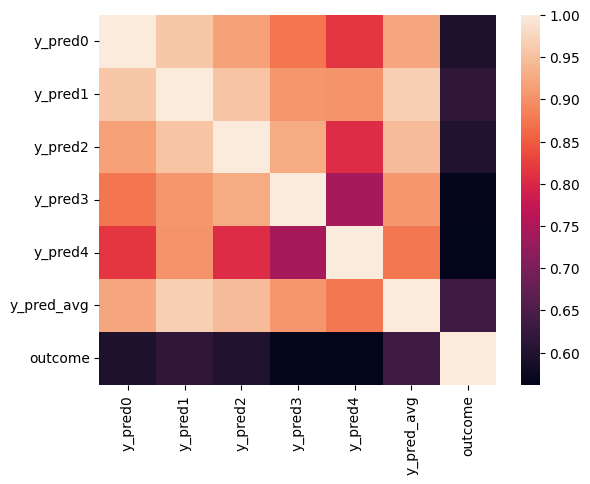

In [62]:
sns.heatmap(y_df.corr())

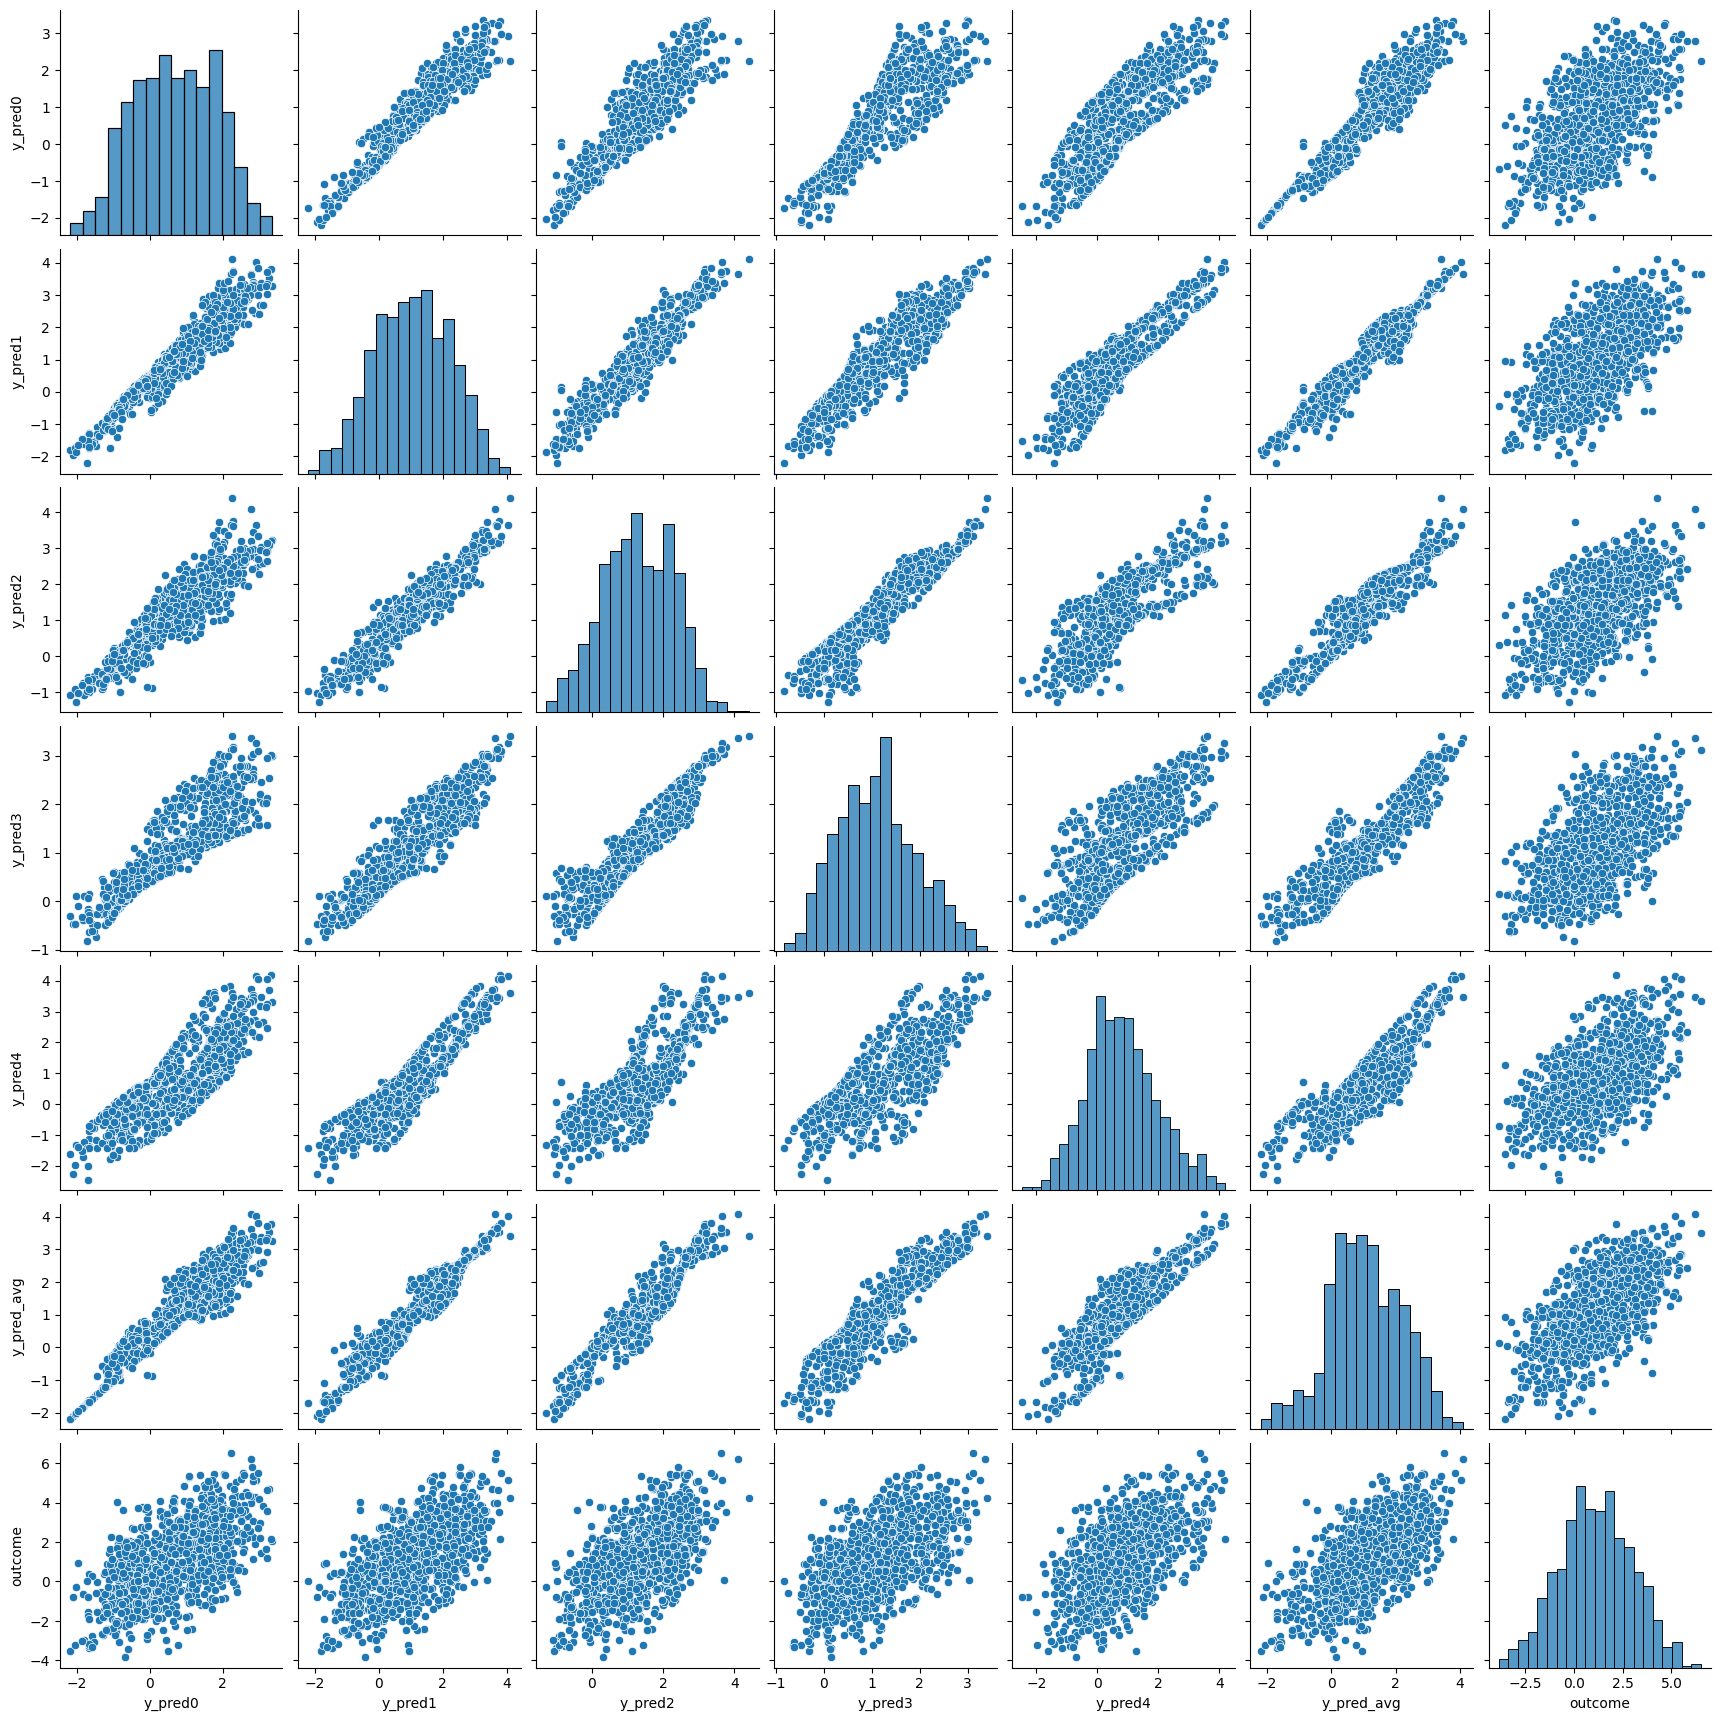

In [63]:
sns.pairplot(y_df)

<Axes: >

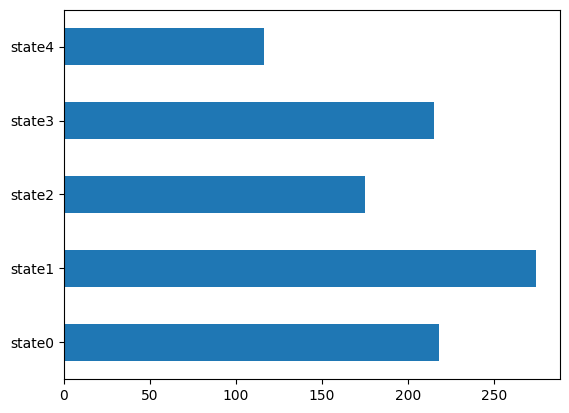

In [64]:
weights_df.sum().plot.barh()

## Estimating the Treatment Effect

Now that we have a cross-validated, causal loss optimized model and did some basic sanity checking of results, we can go ahead and estimate treatment effects.

`pypsps` supports prediction of 2 effects

* UTE: unit-level treatment effects

* ATE: average treatment effect


Since we simulated the data we can lookup the true values for UTE, ATE, and propensity score (the likelihood that an individual in the sample was treated).

In [81]:
print("True ATE: %.2f" % ld_data.true_ate)
print("Naive ATE: %.2f" % ld_data.naive_ate())

True ATE: 2.00
Naive ATE: 1.33


In [73]:
ld_data.true_ute.value_counts()

true_ute
2.0    521
0.0    479
Name: count, dtype: int64

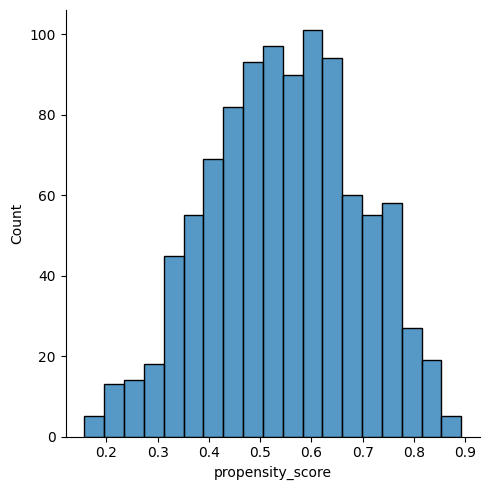

In [75]:
sns.displot(ld_data.true_propensity_score)

Below are the estimates given the trained `model` and features `X_s`.

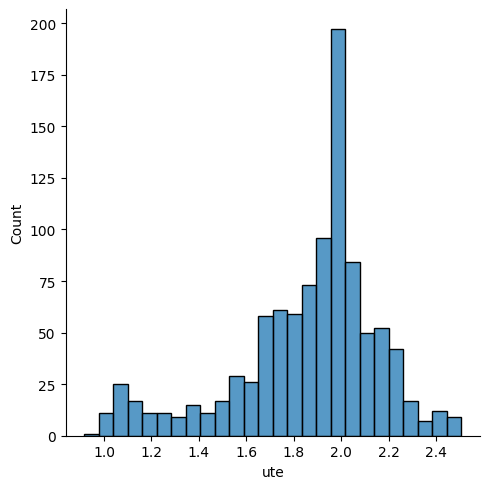

In [76]:
sns.displot(pypsps.inference.predict_ute_binary(model, X_s))

In [83]:
print("Estimated ATE: %.2f" % pypsps.inference.predict_ate_binary(model, X_s))

Estimated ATE: 1.86


The estimated ATE = ~1.86 is quite close to the true value of 2.0.

### Bootstrap

To get an estimate of uncertainty of the ATE estimate, `pypsps` also supports a (basic) bootstrap estimate.  Note that this does not include estimation uncertainty of the parameters, just sampling uncertainty (of features).

In [86]:
import pypsps.bootstrap

ate_boot = pypsps.bootstrap.bootstrap_ate_binary(model, X_s)

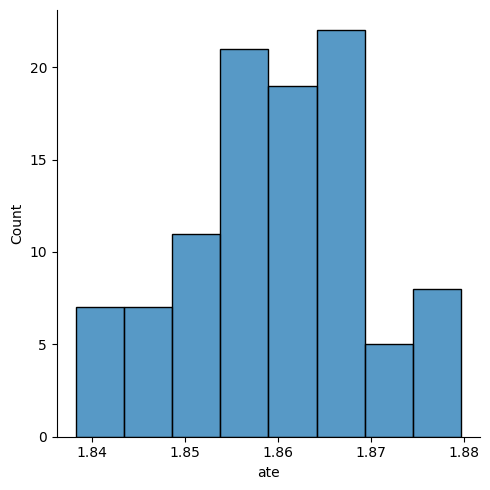

In [88]:
sns.displot(ate_boot)

While this captures some uncerainty from sampling, it is too narrow as it does not capture uncertainty in the network weight estimates.  This requires other techniques (potentially re-fitting same network multiple times or Bayesian -- `tensorflow-probability` -- layers).

# Appendix (debug)
